# STK Object Model Walkthrough using Python

## Uncomment and run the cell below the first time you connect to STK with Python on a new computer

In [1]:
# # Import the comtypes package to connect to an external application
# import comtypes
# from comtypes.client import CreateObject

# # Create a new instance of STK
# app = CreateObject('STK12.Application')
# app.Visible = True # Needed to view the user interface application

# # Get the IAgStkObjectRoot interface
# root = app.Personality2

# # Note: When 'root=uiApplication.Personality2' is executed, the comtypes library automatically creates a gen folder that contains
# # STKObjects and other Python wrappers for the STK libraries. After running this at least once on your computer, the libraries 
# # should be imported before the 'uiApplication=CreateObject("STK12.Application")' line for improved performance.

# # The Astrogator wrapper needs to specifically be loaded with the line below, then AgStkGatorLib is created.
# comtypes.client.GetModule((comtypes.GUID("{FEAEF02E-48CE-42AE-B99B-FB9871A69E4B}") ,1,0))

# # View the location and newly generated wrappers
# import os as os
# print(comtypes.client.gen_dir, '\n')
# print(os.listdir(comtypes.client.gen_dir))

# # After running this cell comment out this cell.
# # Use "Ctrl" + "a" to select all of the cell content, then Use "Ctrl" + "/" to toggle comments in Jupyter Notebooks

## After running the cell above, you can import the packages directly

## A line of code must be added where the comments say ACTION ##

In [2]:
# Import the needed packages
import comtypes
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import AgSTKVgtLib

In [3]:
# Create a new instance of STK
app = CreateObject('STK12.Application')
app.Visible = True
app.UserControl= True
# Alternatively attach to an existing instance of STK, use the handle app
# app = GetActiveObject('STK11.Application')

## Build the scenario ## 

In [4]:
# Get the IAgStkObjectRoot interface, use the handle root
root = app.Personality2
# Personality2 is AGI's way for refering to the 2nd implementation of the Object Model

In [5]:
# Create a new scenario called 'STKPythonTutorial' with the handle sc
root.NewScenario('STKPythonTutorial')
# Attach to an existing Scenario
sc = root.CurrentScenario

In [6]:
# Reposition the STK application
from win32api import GetSystemMetrics
app.Top=0
app.Left=0
app.Width=int(GetSystemMetrics(0)/2)
app.Height=int(GetSystemMetrics(1)-30)

In [7]:
# View the classes of each object
print(type(app))
print(type(root))
print(type(sc))
# The IAgSTKObject contains properties generic to all STK objects

<class 'comtypes.POINTER(_IAgUiApplication)'>
<class 'comtypes.POINTER(_IAgStkObjectRoot)'>
<class 'comtypes.POINTER(IAgStkObject)'>


In [8]:
# Cast sc into an IAgScenario called sc2 to get Scenario specific properties
sc2 = sc.QueryInterface(STKObjects.IAgScenario)
# Double check the type is now an IAgScenario
type(sc2)

comtypes.POINTER(IAgScenario)

In [9]:
# Set the Scenario time period
time1 = 'Today'
time2 = '+24'
# ACTION: Use time1 and time2 to set the scenario time period 
sc2.SetTimePeriod(time1,time2);

In [10]:
# Rewind the scenario to the start time
root.Rewind();

### Add a Facility ###

In [11]:
# Add a new facility called 'AGI_Greenbelt' with the handle fac
fac = sc.Children.New(STKObjects.eFacility,'AGI_Greenbelt')
# Cast fac into an IAgFacility called fac2
fac2 = fac.QueryInterface(STKObjects.IAgFacility)

In [12]:
# Assign a new geodetic position
lat = 39.0095
lon = -76.896
alt = 0
# ACTION: Set the facility's location using lat, lon and alt
fac2.Position.AssignGeodetic(lat,lon,alt);

### Add Satellites ###

In [13]:
# Add a new satellite called 'LEOSat' with the handle sat
sat = sc.Children.New(STKObjects.eSatellite, 'LEOSat')
# Get the IAgSatellite interface with the handle sat2
sat2 = sat.QueryInterface(STKObjects.IAgSatellite)

In [14]:
# View Supported Propagator Types
sat2.PropagatorSupportedTypes

((16, '11Parameter'),
 (12, 'Astrogator'),
 (14, 'GPS'),
 (0, 'HPOP'),
 (1, 'J2Perturbation'),
 (2, 'J4Perturbation'),
 (3, 'LOP'),
 (13, 'RealTime'),
 (4, 'SGP4'),
 (17, 'SP3'),
 (5, 'SPICE'),
 (6, 'StkExternal'),
 (7, 'TwoBody'),
 (8, 'UserExternal'))

In [15]:
# Set the Propagator to J2Perturbation
sat2.SetPropagatorType(STKObjects.ePropagatorJ2Perturbation);
# Grab a handle for the satellite propagator called prop
prop = sat2.Propagator
# View the type of the propagator
type(prop)
# Check the Programming Help for the class type

comtypes.POINTER(IAgVePropagator)

In [16]:
# Cast prop to the IAgVePropagatorJ2Perturbation interface with the handle prop2
prop2 = prop.QueryInterface(STKObjects.IAgVePropagatorJ2Perturbation)

In [17]:
# Propagate the satellite. The UI will now reflect the changes to the propagator
prop2.Propagate();

In [18]:
# Update the satellite's Epoch 
epoch = '17 Sep 2018 00:00:00.000'
prop2.InitialState.Epoch = epoch

In [19]:
# Determine the type of prop2.InitialState.Representation
type(prop2.InitialState.Representation)
# Look up the class in the Programming Help

comtypes.POINTER(IAgOrbitState)

In [20]:
# Assign the satellite's orbit state using the classical orbital elements in the ICRF Coordinate System
coordSys = 11
sma = 7000
e = 0.01
i = 90
aop = 270
raan = 90
ma = 10
# ACTION: Assign the orbital elements and propagate the satellite.
prop2.InitialState.Representation.AssignClassical(coordSys,sma,e,i,aop,raan,ma)
# ACTION: Propagate the satellite
prop2.Propagate();

In [21]:
# Use the New Connect Command to create a 2nd satellite called ConnectSat. Reference the Programming Help
cmd = 'New / */Satellite ConnectSat'
root.ExecuteCommand(cmd);

In [22]:
# Use the following command to set the state of ConnectSat
# ACTION: Use the scenario start and stop time in the connect command. Fill in the blanks.
cmd = 'SetState */Satellite/ConnectSat Classical TwoBody "' + sc2.StartTime + '" "'+ sc2.StopTime +'" 60 ICRF "'+ sc2.StartTime + '" 7000000.0 0.01 90 270 0 10.0'
print(cmd)
# ACTION: Execute the Connect Command
root.ExecuteCommand(cmd);

SetState */Satellite/ConnectSat Classical TwoBody "6 Nov 2018 05:00:00.000" "7 Nov 2018 05:00:00.000" 60 ICRF "6 Nov 2018 05:00:00.000" 7000000.0 0.01 90 270 0 10.0


In [23]:
# Use the root to get a handle called conSat for ConnectSat by getting the object from a file path
conSat = root.GetObjectFromPath('*/Satellite/ConnectSat')

In [24]:
# ACTION: Grab the IAgSatellite interface called conSat2
conSat2 = conSat.QueryInterface(STKObjects.IAgSatellite)

In [25]:
# Change ConnectSat's color
basicAtt = conSat2.Graphics.Attributes.QueryInterface(STKObjects.IAgVeGfxAttributesBasic)
basicAtt.Color = 16776960 # hexadecimal to decimal of the BGR value

## Using Analysis Workbench ##

In [26]:
# Create a new vector from the vector factory
vecFac = sat.Vgt.Vectors.Factory
type(vecFac)
# Create a new displacement vector
try:
    toFac = vecFac.Create('ToAGI_Greenbelt','Description',AgSTKVgtLib.eCrdnVectorTypeDisplacement)
except:
    toFac = sat.Vgt.Vectors.Item('ToAGI_Greenbelt')
type(toFac)

comtypes.POINTER(IAgCrdnVector)

In [27]:
# ACTION: Get a handle for the interface allowing you to access the displacement vector properties 
toFac2 = toFac.QueryInterface(AgSTKVgtLib.IAgCrdnVectorDisplacement)

In [28]:
# Ensure the vector goes from LEOSat to AGI_Greenbelt
toFac2.Origin.SetPath('Satellite/LEOSat Center')
toFac2.Destination.SetPath('Facility/AGI_Greenbelt Center');

In [29]:
# Add the newly created vector to LEOSat
vecVO = sat2.VO.Vector.RefCrdns.Add(0,'Satellite/LEOSat ToAGI_Greenbelt')
vecVO.Visible = 1

## Calculate Access  ##

In [30]:
# Get access to AGI_Greenbelt
access = sat.GetAccessToObject(fac2)

In [31]:
# ACTION: Compute the access
access.ComputeAccess();

In [32]:
# Push the computed access intervals into an array called accessTimes
accessTimes = access.ComputedAccessIntervalTimes.ToArray(0, -1)
# If the types are not all numeric, then the array will actually be a tuple

In [33]:
# Import numpy and pandas to help out
import numpy as np
import pandas as pd

In [34]:
# Converts the tuple into an array and then displays the data
accessTimes = np.asarray(accessTimes)
df = pd.DataFrame({'Start Time':accessTimes[:,0],'Stop Time':accessTimes[:,1]})
df

,Start Time,Stop Time
0,6 Nov 2018 06:39:20.349,6 Nov 2018 06:48:52.610
1,6 Nov 2018 08:14:23.724,6 Nov 2018 08:26:58.207
2,6 Nov 2018 09:56:14.114,6 Nov 2018 10:01:07.890
3,6 Nov 2018 18:26:51.911,6 Nov 2018 18:35:42.321
4,6 Nov 2018 20:02:35.168,6 Nov 2018 20:15:15.172
5,6 Nov 2018 21:41:41.752,6 Nov 2018 21:48:35.619


## Pulling Data Providers ##

In [35]:
# Extract the folder called 'Cartesian Velocity' into the handle cartVel
cartVel = sat.DataProviders.Item("Cartesian Velocity")
# View the type of cartVel
type(cartVel)

comtypes.POINTER(IAgDataProviderInfo)

In [36]:
# Cast cartVel into an IAgDataProviderGroup
cartVel = cartVel.QueryInterface(STKObjects.IAgDataProviderGroup)

In [37]:
# Grab a handle for the ICRF folder called CartVelICRF
cartVelICRF = cartVel.Group.Item("ICRF")

In [38]:
# ACTION: Recast cartVelICRF to an IAgDataPrvTimeVar
cartVelICRF = cartVelICRF.QueryInterface(STKObjects.IAgDataPrvTimeVar)
type(cartVelICRF)

comtypes.POINTER(IAgDataPrvTimeVar)

In [39]:
# Extract the Time, speed, radial and in-track data providers. Save the output as result
elems = ['Time','speed','radial','in-track']
startTime = sc2.StartTime
stopTime = sc2.StopTime
timeStep = 60

# ACTION: Execute the desired elements, using the scenario start and stop time and with the desired time step
result = cartVelICRF.ExecElements(startTime,stopTime,timeStep,elems)

In [40]:
# Grab each the values from each DataSet
time = result.DataSets.Item(0).GetValues()
speed = result.DataSets.Item(1).GetValues()
radial = result.DataSets.Item(2).GetValues()
intrack = result.DataSets.Item(3).GetValues()

## Viewing Results ##

In [41]:
# Use Pandas to show the Satellite Velocity Data
df = pd.DataFrame({'Time':time,'Speed':speed,'Radial':radial,'In-Track':intrack});
df.head(10)

,In-Track,Radial,Speed,Time
0,7.567318,-0.072516,7.567666,6 Nov 2018 05:00:00.000000000
1,7.571988,-0.071005,7.572321,6 Nov 2018 05:01:00.000000000
2,7.576554,-0.069191,7.576870,6 Nov 2018 05:02:00.000000000
3,7.580999,-0.067081,7.581295,6 Nov 2018 05:03:00.000000000
4,7.585301,-0.064684,7.585577,6 Nov 2018 05:04:00.000000000
5,7.589442,-0.062007,7.589695,6 Nov 2018 05:05:00.000000000
6,7.593404,-0.059063,7.593633,6 Nov 2018 05:06:00.000000000
7,7.597168,-0.055862,7.597373,6 Nov 2018 05:07:00.000000000
8,7.600718,-0.052419,7.600899,6 Nov 2018 05:08:00.000000000
9,7.604038,-0.048747,7.604194,6 Nov 2018 05:09:00.000000000


In [42]:
# Import matlplotlib.pyplot to plot the speed
import matplotlib.pyplot as plt

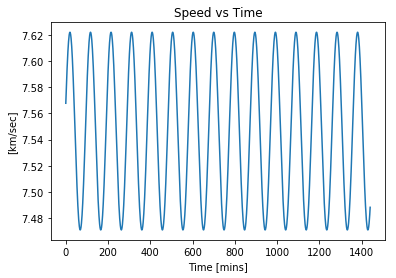

In [43]:
# Plot the speed vs time
plt.plot(speed)
plt.xlabel('Time [mins]')
plt.ylabel('[km/sec]')
plt.title('Speed vs Time')
plt.show()

## Save and Close ##

In [44]:
# Create a folder to save the scenario and contents
# import os as os
# userDir = root.ExecuteCommand('GetDirectory / DefaultUser').Item(0)
# saveFolder =  userDir + '\\' + sc.InstanceName
# os.mkdir(saveFolder)
# # Save the scenario
# root.SaveAs(saveFolder + '\\' + sc.InstanceName)
# print(saveFolder)

In [45]:
# Delete the handles and close STK
# del root; 
# app.Quit();
# del app;